**Topic:** Kaggle Challenge [Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs/data)

Which of the provided pairs of questions contain two questions with the same meaning? The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. The labels, on the whole, represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.


**Scores:**

 - log_loss: official competition score
 - accuracy: relevant in real life

**General workflow:**

- load train data set
- cleanup (NaN's, non-English)
- tokenize
- perform semantic indexing/analysis
- compute similarity scores per pair
- train a classification algorithm for score -> is duplicate prediction
- compute scores for the test set

In [1]:
import sys
import os
import time
import gzip
import re

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import numpy as np
import pandas as pd

In [3]:
try:
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
except (NameError) as e:
    print("{}: No matplotlib graphics".format(e))
    plt = None

In [4]:
# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
import sklearn.metrics.pairwise as smp
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF

In [5]:
# gensim
from gensim import corpora, models, similarities, matutils, \
    __version__ as gensim_version
gensim_version

2018-03-07 05:26:49,642 : INFO : 'pattern' package not found; tag filters are not available for English


'3.4.0'

In [6]:
# Load the cleaned train set:
clean_file = './data/quora/clean.csv.gz'
df = pd.read_csv(clean_file, header=0)
df.shape

(381310, 3)

In [7]:
from sklearn.utils import shuffle

ratio_1 = df['is_duplicate'].mean()
subset_size = -1 # 10000

if subset_size > 0:
    # Use a smaller sub-set to speed up the process; preserve the ratio
    # of is_duplicate:
    n_samples = min(subset_size, df.shape[0]-1)

    n_samples_1 = int(ratio_1 * n_samples)
    use_df = pd.concat([
            shuffle(df[df['is_duplicate'] == 0], n_samples=(n_samples - n_samples_1)),
            shuffle(df[df['is_duplicate'] == 1], n_samples=n_samples_1)
        ],
        ignore_index=True
    )
else:
    use_df = df
    
use_df.shape

(10000, 3)

Extract the questions and the target flag:

In [8]:
q1 = use_df['question1'].values
q2 = use_df['question2'].values
is_dup = use_df['is_duplicate'].values

Minimal EDA, look for duplicate questions:

In [9]:
q1_unique, q1_unique_counts = \
    np.unique(q1, return_index=False, return_inverse=False, return_counts=True)

In [10]:
q1_num_dups, q1_dups_dist = \
    np.unique(q1_unique_counts, return_index=False, return_inverse=False, return_counts=True)

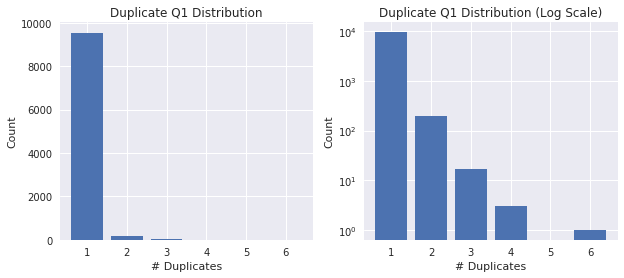

In [11]:
if plt:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    xticks = np.arange(q1_num_dups.min(), q1_num_dups.max()+1)

    ax[0].bar(q1_num_dups, q1_dups_dist)
    #ax[0].set_xticks(xticks)
    ax[0].set_title("Duplicate Q1 Distribution")
    ax[0].set_xlabel("# Duplicates")
    ax[0].set_ylabel("Count")

    ax[1].bar(q1_num_dups, q1_dups_dist, log=True)
    #ax[1].set_xticks(xticks)
    ax[1].set_title("Duplicate Q1 Distribution (Log Scale)")
    ax[1].set_xlabel("# Duplicates")
    ax[1].set_ylabel("Count")

    plt.show()

Split 80/20 train/test:

In [12]:
q1_train, q1_test, \
    q2_train, q2_test, \
    is_dup_train, is_dup_test = \
        train_test_split(q1, q2, is_dup, test_size=.2, stratify=is_dup)

Vectorize the text; use both q1 and q2 (why? TBD):

In [13]:
import nltk
stemmer = nltk.stem.porter.PorterStemmer().stem

def tokenizer(doc, min_len=2):
    # Normalize case:
    doc = doc.lower()
    # Separate on non-alpha:
    tokens = re.split(r'[^a-z0-9]+', doc)
    # Return all the tokens len >= min_len, stemmed:
    words = filter(lambda t: len(t) >= min_len, tokens)
    if stemmer:
        words = map(stemmer, words)
    return list(words)

In [14]:
cvec = CountVectorizer(
    ngram_range=(1, 2), 
    stop_words="english", 
    token_pattern=r'(?i)\b[a-z]{2,}\b', #words with >= 2 alpha chars,
    tokenizer=tokenizer,
)

cvec.fit(np.concatenate((q1_train, q2_train)))
id2word = dict((v, k) for k, v in cvec.vocabulary_.items())

q1_train_tfidf = cvec.transform(q1_train)
q1_train_corpus = matutils.Sparse2Corpus(q1_train_tfidf.transpose())

q2_train_tfidf = cvec.transform(q2_train)
q2_train_corpus = matutils.Sparse2Corpus(q2_train_tfidf.transpose())

q1_test_tfidf = cvec.transform(q1_test)
q1_test_corpus = matutils.Sparse2Corpus(q1_test_tfidf.transpose())

q2_test_tfidf = cvec.transform(q2_test)
q2_test_corpus = matutils.Sparse2Corpus(q2_test_tfidf.transpose())

In [15]:
word_vectorizer = repr(cvec) + ' + custom tokenizer + stemmer'

Build LDA model on based on q1:

In [16]:
num_topics = 100
lda = models.ldamulticore.LdaMulticore(
    q1_train_corpus, id2word=id2word, num_topics=num_topics,
    workers=7, passes=10
)

2018-03-07 05:26:57,642 : INFO : using symmetric alpha at 0.002
2018-03-07 05:26:57,643 : INFO : using symmetric eta at 0.002
2018-03-07 05:26:57,649 : INFO : using serial LDA version on this node
2018-03-07 05:27:01,913 : INFO : running online LDA training, 500 topics, 10 passes over the supplied corpus of 8000 documents, updating every 14000 documents, evaluating every ~8000 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-07 05:27:01,914 : INFO : training LDA model using 7 processes
2018-03-07 05:27:01,953 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/8000, outstanding queue size 1
2018-03-07 05:27:02,499 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/8000, outstanding queue size 2
2018-03-07 05:27:02,506 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/8000, outstanding queue size 3
2018-03-07 05:27:02,513 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/8000, outst

2018-03-07 05:28:10,391 : INFO : PROGRESS: pass 4, dispatched chunk #2 = documents up to #6000/8000, outstanding queue size 3
2018-03-07 05:28:10,398 : INFO : PROGRESS: pass 4, dispatched chunk #3 = documents up to #8000/8000, outstanding queue size 4
2018-03-07 05:28:21,013 : INFO : topic #396 (0.002): 0.008*"remov" + 0.008*"doe" + 0.008*"3d" + 0.007*"use" + 0.005*"whi" + 0.004*"stupid" + 0.004*"rural" + 0.004*"death" + 0.004*"rural area" + 0.004*"music consid"
2018-03-07 05:28:21,014 : INFO : topic #290 (0.002): 0.010*"energi" + 0.010*"african" + 0.009*"rich" + 0.008*"countri" + 0.007*"polar" + 0.007*"did" + 0.007*"doe" + 0.007*"expans" + 0.007*"way" + 0.007*"differ"
2018-03-07 05:28:21,015 : INFO : topic #255 (0.002): 0.014*"best" + 0.010*"day" + 0.010*"visit" + 0.008*"men" + 0.008*"like" + 0.007*"complet" + 0.007*"goa" + 0.007*"car" + 0.007*"visit goa" + 0.007*"goa day"
2018-03-07 05:28:21,015 : INFO : topic #422 (0.002): 0.013*"engin" + 0.009*"pune" + 0.006*"softwar engin" + 0.006

2018-03-07 05:29:24,027 : INFO : topic #60 (0.002): 0.020*"whi" + 0.015*"post" + 0.010*"naruto" + 0.007*"did" + 0.007*"theme" + 0.007*"episod" + 0.007*"relat" + 0.007*"relat episod" + 0.007*"anim" + 0.007*"episod naruto"
2018-03-07 05:29:24,072 : INFO : topic diff=inf, rho=0.277350
2018-03-07 05:29:29,092 : INFO : -15.640 per-word bound, 51071.7 perplexity estimate based on a held-out corpus of 2000 documents with 19684 words
2018-03-07 05:29:29,100 : INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #2000/8000, outstanding queue size 1
2018-03-07 05:29:29,638 : INFO : PROGRESS: pass 9, dispatched chunk #1 = documents up to #4000/8000, outstanding queue size 2
2018-03-07 05:29:29,645 : INFO : PROGRESS: pass 9, dispatched chunk #2 = documents up to #6000/8000, outstanding queue size 3
2018-03-07 05:29:29,652 : INFO : PROGRESS: pass 9, dispatched chunk #3 = documents up to #8000/8000, outstanding queue size 4
2018-03-07 05:29:39,444 : INFO : topic #5 (0.002): 0.015*"date" + 

In [17]:
nlp_model = 'LDA(num_topics={})'.format(num_topics)

Transform q1, q2 into LDA space: 

In [18]:
q1_train_lda = lda[q1_train_corpus]
q2_train_lda = lda[q2_train_corpus]

q1_test_lda = lda[q1_test_corpus]
q2_test_lda = lda[q2_test_corpus]

Iterate through the 2 lists and compute the cosine similarity:

In [19]:
from  gensim.matutils import cossim

def cos_sim(v1, v2):
    if not v1 or not v2:
        return np.nan
    return cossim(v1, v2)

def cos_sim_list(q1_lda, q2_lda):
    return np.array(list(map(lambda s: cos_sim(*s), zip(q1_lda, q2_lda))))

In [20]:
sim12_train = cos_sim_list(q1_train_lda, q2_train_lda)
sim12_test = cos_sim_list(q1_test_lda, q2_test_lda)

Use K Nearest Neighbors to map similarities into is_dup labels:

In [21]:
# Beware of NaN's:
train_index = ~np.isnan(sim12_train)
X_train = sim12_train[train_index].reshape(-1, 1)
y_train = is_dup_train[train_index]

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=500, p=1)
knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=500, p=1,
           weights='uniform')

In [23]:
classifier = repr(knc)

Compute the score:

In [24]:
from sklearn.metrics import log_loss, accuracy_score

# Baseline score, assume random guessing with ratio_1 probability for 1:
accuracy_baseline = accuracy_score(
    is_dup, 
    np.random.binomial(1, ratio_1, size=len(is_dup))
)
logloss_baseline = log_loss(
    is_dup,
    np.full_like(is_dup, ratio_1, dtype=np.float64)
)

def compile_results(X, y_true, estimator):
    # Beware of NaN's in X:
    non_nan_index = ~np.isnan(X)
    n_pred = np.count_nonzero(non_nan_index)
    n_guess = len(non_nan_index) - n_pred
    X_pred = X[non_nan_index].reshape(-1, 1)

    y_pred = np.zeros_like(y_true)
    y_pred[non_nan_index] = estimator.predict(X_pred)
    y_pred[~non_nan_index] = np.random.binomial(1, ratio_1, size=n_guess)
    accuracy = accuracy_score(y_true, y_pred)

    if hasattr(estimator, 'predict_proba'):
        y_pred_proba = np.full_like(y_true, ratio_1, dtype=np.float64)
        y_pred_proba[non_nan_index] = estimator.predict_proba(X_pred)[:,1]
        logloss = log_loss(y_true, y_pred_proba)
    else:
        logloss = None
    
    wrong_index = y_true != y_pred
    wrong_pred_index = np.argwhere(wrong_index & non_nan_index).flatten()
    wrong_guess_index = np.argwhere(wrong_index & ~non_nan_index).flatten()

    return accuracy, logloss, y_pred, wrong_pred_index, wrong_guess_index, n_pred, n_guess

def print_results(accuracy, logloss, wrong_pred_index, 
                  wrong_guess_index, n_pred, n_guess, for_set='test', f=None):
    print("Accuracy {} score = {:.03f}, baseline = {:.03f}, higher is better".format(
            for_set,
            accuracy,
            accuracy_baseline),
        file=f
    )
    if logloss is not None:
        print("Log loss {} score = {:.03f}, baseline = {:.03f}, lower is better".format(
            for_set,
            logloss,
            logloss_baseline),
        file=f
    )
    print("Wrong {} predictions: {}/{} ({:.03f})".format(
            for_set,
            len(wrong_pred_index), n_pred,
            len(wrong_pred_index)/n_pred if n_pred else 0),
        file=f
    )
    print("Wrong {} guesses: {}/{} ({:.03f})".format(
            for_set,
            len(wrong_guess_index), n_guess,
            len(wrong_guess_index)/n_guess if n_guess else 0),
        file=f
    )
    print(file=f)
          
def wrong_pred(i, q1, q2, is_dup, y_pred, sim12, f=None):
    print("Q1: {!r}".format(q1[i]), file=f)
    print("Q2: {!r}".format(q2[i]), file=f)
    print("is_dup={}, pred={}, sim={:.03f}".format(
            is_dup[i], y_pred[i], sim12[i]
        ),
        file=f  
    )
    print(file=f)
    
def print_mistakes(q1, q2, is_dup, y_pred, sim12,
               wrong_pred_index, wrong_guess_index,
               for_set='test', f=None):
    print("Wrong {} predictions:".format(for_set), file=f)
    print(file=f)
    for i in wrong_pred_index:
        wrong_pred(i, q1, q2, is_dup, y_pred, sim12, f)
    print(file=f)
    print("Wrong {} guesses:".format(for_set), file=f)
    print(file=f)

    for i in wrong_guess_index:
        wrong_pred(i, q1, q2, is_dup, y_pred, sim12, f)
    print(file=f)
       
def audit_info(train_sz=None, test_sz=None, 
               word_vectorizer=None, nlp_model=None, classifier=None, f=None):
    print("Time:       {}".format(
            time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(report_time))
        ),
        file=f
    )
    print("Train/Test: {}/{}".format(train_sz, test_sz), file=f)
    print("Vectorizer: {}".format(word_vectorizer), file=f)
    print("NLP Model:  {}".format(nlp_model), file=f)
    print("Classifier: {}".format(classifier), file=f)
    print(file=f)

In [25]:
report_time = time.time()

accuracy_test, logloss_test, y_pred_test, wrong_pred_index_test, \
    wrong_guess_index_test, n_pred_test, n_guess_test = \
        compile_results(sim12_test, is_dup_test, knc)

In [26]:
print_results(accuracy_test, logloss_test, wrong_pred_index_test,
        wrong_guess_index_test, n_pred_test, n_guess_test)

audit_file = 'data/quora/audit-{}-{}.log.gz'.format(
    time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(report_time)),
    os.getpid()
)
with gzip.open(audit_file, 'wt') as f:
    audit_info(
        len(is_dup_train), len(is_dup_test),
        word_vectorizer, nlp_model, classifier, f=f)
    print_results(accuracy_test, logloss_test, wrong_pred_index_test,
        wrong_guess_index_test, n_pred_test, n_guess_test, f=f)
    print_mistakes(q1_test, q2_test, is_dup_test, y_pred_test, sim12_test,
               wrong_pred_index_test, wrong_guess_index_test, f=f)

print("Audit file = {}".format(audit_file))

Accuracy test score = 0.623, baseline = 0.530, higher is better
Log loss test score = 0.631, baseline = 0.659, lower is better
Wrong test predictions: 749/1985 (0.377)
Wrong test guesses: 6/15 (0.400)

Audit file = data/quora/audit-2018-03-07-05-30-21-3652.log.gz
